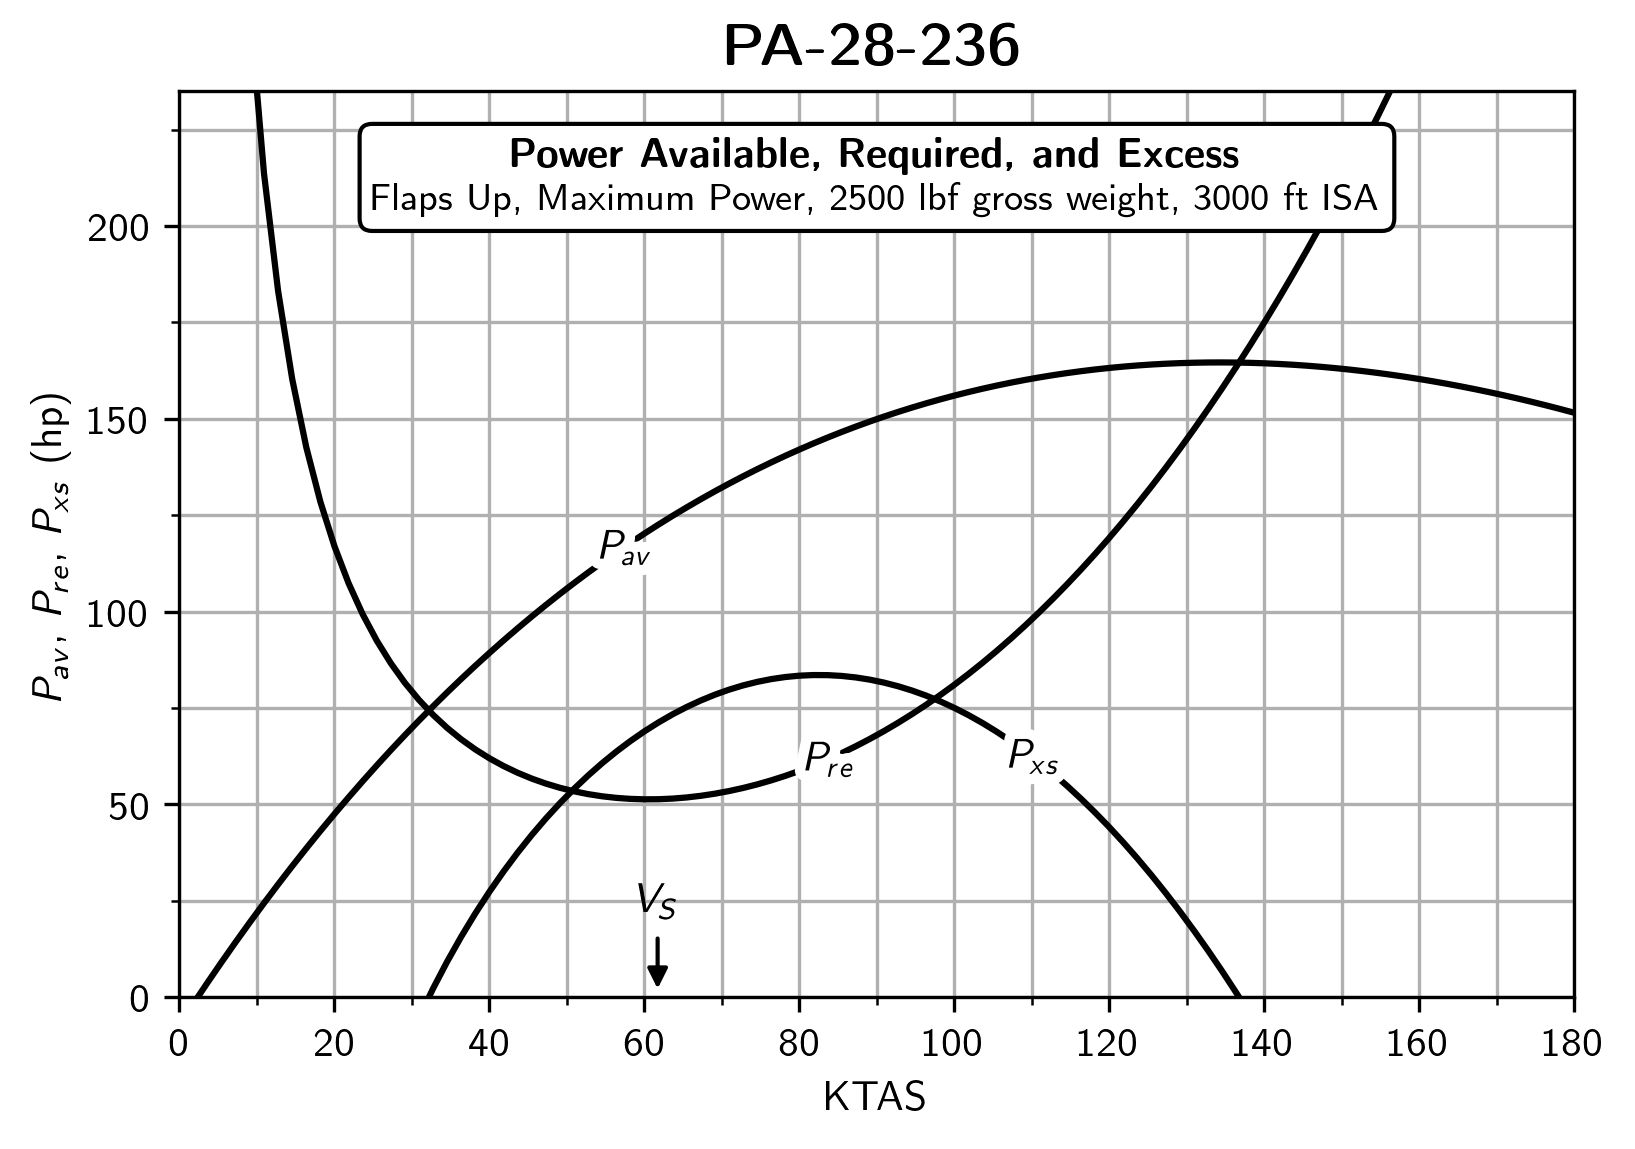

In [108]:
from the_bootstrap_approach.airspeed_calibration import ias_to_cas

%reload_ext autoreload
%autoreload 2

from labellines import labelLines
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

from the_bootstrap_approach.conditions import FullThrottleConditions
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.mixture import Mixture
from the_bootstrap_approach.propeller_chart import propeller_efficiency

from n51sw_dataplate import N51SW

operating_conditions = FullThrottleConditions(
    N51SW, 2500, 3000, british_standard_temperature(3000), Mixture.BEST_POWER, 2400
)

plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{sansmathfonts}\usepackage[T1]{fontenc}",
        "font.family": "sans-serif",
        "ps.usedistiller": "xpdf",
    }
)

fig, ax = plt.subplots()

# Never exceed speed for a Piper Dakota is 171 KCAS.
never_exceed_speed = tas(171, operating_conditions.relative_atmospheric_density)
# Round up to the nearest 10 KTAS.
never_exceed_speed = int(math.ceil(never_exceed_speed / 10.0)) * 10
ktas = np.linspace(0, never_exceed_speed, 100)[1:]

p_av = (
    power_available(
        propeller_efficiency(
            sdef_t(N51SW.z_ratio),
            propeller_advance_ratio(
                kn_to_fts(ktas),
                operating_conditions.propeller_rps,
                N51SW.propeller_diameter,
            ),
            propeller_power_coefficient(
                operating_conditions.power,
                operating_conditions.atmospheric_density,
                operating_conditions.propeller_rps,
                N51SW.propeller_diameter,
            ),
            power_adjustment_factor_x(N51SW.total_activity_factor),
        ),
        operating_conditions.power,
    )
    # 1 hp is the ability to apply 550 ft-lbf/s.
    / 550
)
ax.plot(ktas, p_av, label="$P_{av}$", color="black")

p_re = (
    power_required(operating_conditions.g, operating_conditions.h, kn_to_fts(ktas))
    / 550
)
ax.plot(ktas, p_re, label="$P_{re}$", color="black")

p_xs = p_av - p_re
ax.plot(ktas, p_xs, label="$P_{xs}$", color="black")

# Determine at what airspeed the excess power curve crosses zero on the Y-axis.
# Limit labelLines within the visible area of the excess power curve.
# https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
zero_crossings = np.where(np.diff(np.sign(p_xs)))[0]
first_zero_crossing = ktas[zero_crossings[0]]
second_zero_crossing = ktas[zero_crossings[1]]

labelLines(
    ax.get_lines(),
    xvals=(first_zero_crossing, second_zero_crossing),
    align=False,
    zorder=2.5,
)

stall_speed = tas(
    scale_v_speed_by_weight(
        ias_to_cas(N51SW, 65), 3000, operating_conditions.gross_aircraft_weight
    ),
    operating_conditions.relative_atmospheric_density,
)

ax.annotate(
    "$V_S$",
    xy=(stall_speed, 0),
    xycoords="data",
    xytext=(0, 20),
    textcoords="offset points",
    ha="center",
    arrowprops=dict(facecolor="black", arrowstyle="-|>", connectionstyle="arc3"),
)

ax.set(
    title="\Large \\textbf{PA-28-236}",
    xlabel="KTAS",
    ylabel="$P_{av}$, $P_{re}$, $P_{xs}$ (hp)",
)

altitude = np.ceil(
    density_altitude(
        operating_conditions.pressure_altitude,
        british_standard_temperature(operating_conditions.pressure_altitude),
    )
)

txt = ax.text(
    0.5,
    0.95,
    (
        "\\textbf{Power Available, Required, and Excess}\n"
        f"\centering \small {N51SW.configuration}, "
        f"{Mixture.BEST_POWER.value} Mixture, "
        f"{operating_conditions.gross_aircraft_weight} lbf gross weight, "
        f"{altitude:.0f} ft ISA"
    ),
    transform=ax.transAxes,
    wrap=True,
    ha="center",
    va="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=1.0),
)


ax.grid(True, which="both")

ax.xaxis.set_minor_locator(AutoMinorLocator((2)))
ax.yaxis.set_minor_locator(AutoMinorLocator((2)))

ax.set_xlim([0, never_exceed_speed])
ax.set_ylim([0, N51SW.rated_full_throttle_engine_horsepower])

fig.set(dpi=300)
plt.show()